# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import helper
data_dir = './data'

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

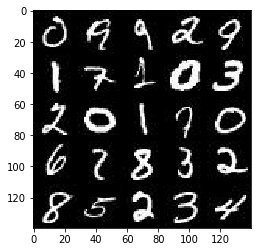

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

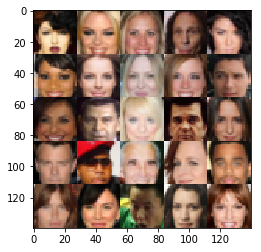

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr_rate = tf.placeholder(tf.float32,  name='lr_rate')

    return real_input, z_input,lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

In [7]:
t_i,t_z,t_lr = model_inputs(28,28,3,100)
print("Real_input shape:{}\nz_input:{}\nlr_rate:{}".format(t_i.get_shape(),t_z.get_shape(),t_lr.get_shape()))

Real_input shape:(?, 28, 28, 3)
z_input:(?, 100)
lr_rate:<unknown>


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
#         print("Input images shape:{}".format(images.get_shape()))
        # Input is batch x 28 x 28 x channel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same') #convolution
        x1 = tf.maximum(alpha*x1,x1)
#         print("x1 shape:{}".format(x1.get_shape()))
        # x1 is now 14 x 14 x 32

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(alpha * x2, x2)
#         print("x2 shape:{}".format(x2.get_shape()))
        #x2 is now 7 x 7 x 64
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #x3 is now 4 x 4 x 256
#         print("x3 shape:{}".format(x3.get_shape()))
        
        #sigmoid layer
        fc_layer = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(fc_layer, 1)
        out = tf.sigmoid(logits)
        
#         print("output shape:{}".format(out.get_shape()))

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        z0 = tf.layers.dense(z, 4* 4 * 512)
        z0 = tf.reshape(z0, (-1, 4,4,512))
        z0 = tf.layers.batch_normalization(z0, training=is_train)
        z0 = tf.maximum(alpha*z0,z0)
#         print("z0 shape:{}".format(z0.get_shape()))
        # now 4x4x512
        
        z1 = tf.layers.conv2d_transpose(z0, 256, 4, strides=1,padding='valid')
        z1 = tf.layers.batch_normalization(z1, training=is_train)
        z1 = tf.maximum(alpha*z1, z1)
#         print("z1 shape:{}".format(z1.get_shape()))
        #z1 is now 7 x 7 x 256

        z2 = tf.layers.conv2d_transpose(z1, 128, 5,strides=2,padding='same')
        z2 = tf.layers.batch_normalization(z2, training=is_train)
        z2 = tf.maximum(alpha * z2,z2)
#         print("Z2 shape:{}".format(z2.get_shape()))
        # z2 is now 14 x 14 x 128
        
        z3 = tf.layers.conv2d_transpose(z2, out_channel_dim, 5, strides=2,padding='same')
#         print("Z3 shape:{}, out_channel_dim:{}".format(z3.get_shape(),out_channel_dim))
        # z3 is now 28 x 28 x out_channel_dim
        out = tf.tanh(z3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_out = generator(input_z, out_channel_dim, is_train=True) #this is a tanh output that looks like input_real
    
    
    d_real_out, d_real_logits = discriminator(input_real, reuse=False)
    d_z_out, d_z_logits = discriminator(g_out,reuse=True)
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_z_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_z_logits, labels = tf.zeros_like(d_z_logits)))
    
    d_loss = d_real_loss + d_z_loss
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_z_logits,labels = tf.ones_like(d_z_logits)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
#     print(trainables)
    d_training = [ w for w in trainables if w.name.startswith('discriminator')]
    g_training = [ w for w in trainables if w.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_training)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_training)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
tf.reset_default_graph()
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 100
    log_every = 100
    
    
    real_input, z_input, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss(real_input,z_input, data_shape[3])
    
    d_train, g_train = model_opt(d_loss, g_loss, lr, beta1)
    
#     saver = tf.train.Saver()
    
    sample, losses = [], []
    step_count=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                step_count+=1
                # Because mnist and celeb dataset are in range -0.5 to 0.5, we want to scale it to -1 to 1
                
                batch_images = batch_images * 2 
#                 print("Batch_image : {}".format(batch_images))
                batch_z = np.random.uniform(-1,1, (batch_size,z_dim))
#                 print(batch_z.shape)
#                 print("Batch_image:{}".format(batch_images.shape))
                #run optimizer
                
                #Train discriminator with real and fake images
                _ = sess.run(d_train, feed_dict={real_input:batch_images,z_input: batch_z, lr:learning_rate })
                
                # Train the generator
                _ = sess.run(g_train, feed_dict={real_input:batch_images,lr:learning_rate, z_input: batch_z})
                
                #Train the generator twice
#                 _ = sess.run(g_train, feed_dict={real_input:batch_images,lr:learning_rate, z_input: batch_z})
                
                
                if (step_count % log_every == 0) or (step_count % print_every == 0):
                    #Show loss
                    dis_loss = d_loss.eval({real_input:batch_images, z_input: batch_z})
                    gen_loss = g_loss.eval({z_input: batch_z})
#                     dis_loss,gen_loss = sess.run([d_loss,g_loss], feed_dict={real_input:batch_images,z_input: batch_z})
                    losses.append((dis_loss,gen_loss))
                    if step_count % print_every ==0:
                        print("Epoch:{} Step:{} Discriminator Loss:{}, Generator Loss:{}".format(epoch,step_count,
                                                                                                 dis_loss,gen_loss))
                        #Show generator output
                        show_generator_output(sess, 1, z_input, data_shape[3], data_image_mode)
                    
                    
#         saver.save(sess,'./checkpoints/generator.chkpt')
    return losses
                

In [26]:
mnist_sample = helper.Dataset('mnist', glob(os.path.join(data_dir, 'test_sample/*.jpg')))

Epoch:3 Step:100 Discriminator Loss:5.617092132568359, Generator Loss:0.010688047856092453


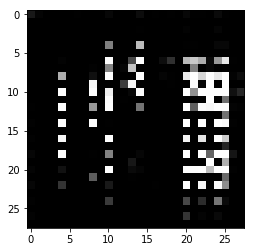

Epoch:6 Step:200 Discriminator Loss:1.2025665044784546, Generator Loss:0.8198163509368896


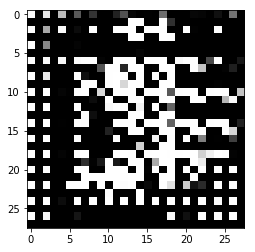

Epoch:9 Step:300 Discriminator Loss:0.5180056691169739, Generator Loss:1.7015459537506104


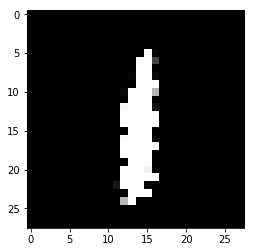

Epoch:12 Step:400 Discriminator Loss:0.11731204390525818, Generator Loss:3.2880802154541016


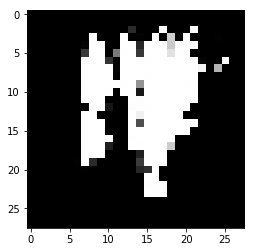

Epoch:15 Step:500 Discriminator Loss:0.04667218402028084, Generator Loss:3.7533810138702393


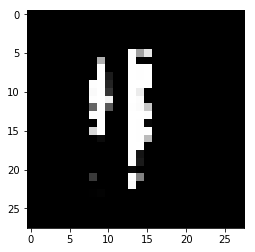

Epoch:18 Step:600 Discriminator Loss:0.0015319925732910633, Generator Loss:7.3057050704956055


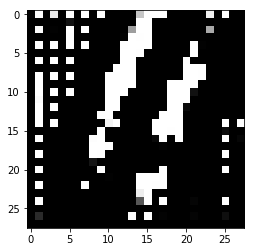

Epoch:21 Step:700 Discriminator Loss:0.10091618448495865, Generator Loss:6.49261474609375


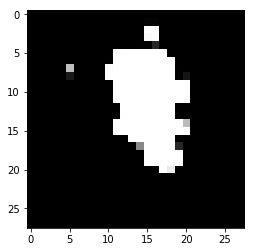

Epoch:24 Step:800 Discriminator Loss:0.0022155167534947395, Generator Loss:9.411765098571777


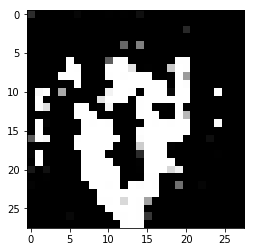

Epoch:27 Step:900 Discriminator Loss:0.028436724096536636, Generator Loss:4.240130424499512


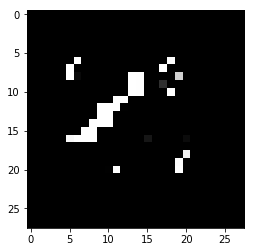

Epoch:30 Step:1000 Discriminator Loss:0.01163759920746088, Generator Loss:4.900125980377197


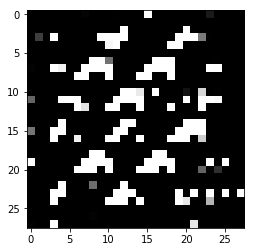

Epoch:33 Step:1100 Discriminator Loss:0.0007103501702658832, Generator Loss:9.035231590270996


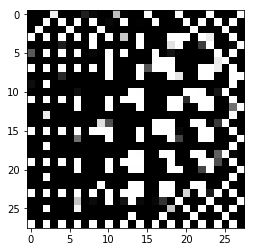

Epoch:36 Step:1200 Discriminator Loss:0.0009898244170472026, Generator Loss:8.336431503295898


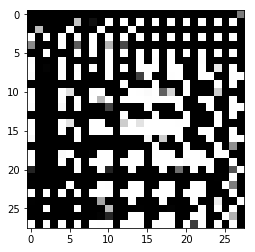

Epoch:39 Step:1300 Discriminator Loss:0.000882031861692667, Generator Loss:7.657954216003418


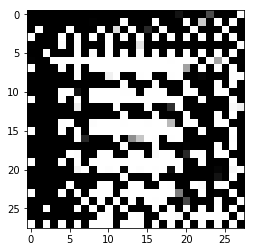

Epoch:42 Step:1400 Discriminator Loss:0.00034884881461039186, Generator Loss:8.60025691986084


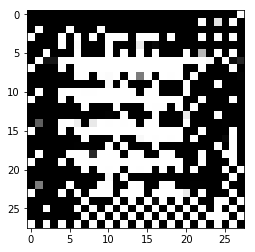

Epoch:45 Step:1500 Discriminator Loss:0.020365122705698013, Generator Loss:4.037943363189697


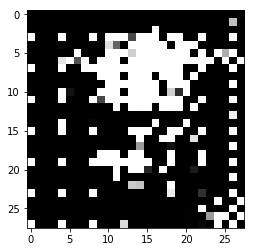

Epoch:48 Step:1600 Discriminator Loss:0.01122343260794878, Generator Loss:4.653020858764648


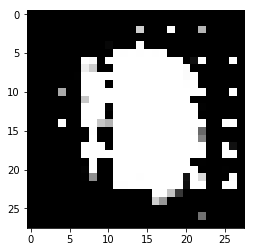

Epoch:51 Step:1700 Discriminator Loss:0.004907017108052969, Generator Loss:5.673641204833984


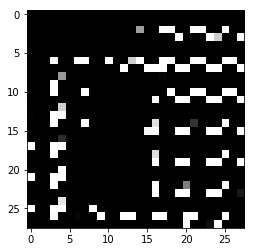

Epoch:54 Step:1800 Discriminator Loss:0.002301056170836091, Generator Loss:6.245078086853027


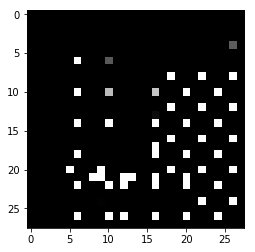

Epoch:57 Step:1900 Discriminator Loss:0.000318017351673916, Generator Loss:8.313549041748047


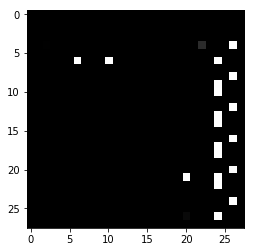

Epoch:60 Step:2000 Discriminator Loss:9.61483019636944e-05, Generator Loss:9.290091514587402


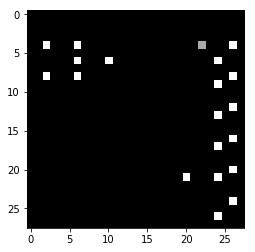

Epoch:63 Step:2100 Discriminator Loss:8.41669607325457e-05, Generator Loss:9.872746467590332


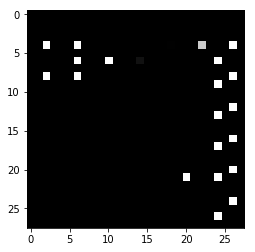

Epoch:66 Step:2200 Discriminator Loss:8.717193122720346e-05, Generator Loss:9.773969650268555


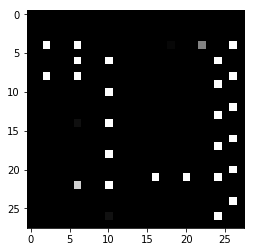

Epoch:69 Step:2300 Discriminator Loss:4.373683623271063e-05, Generator Loss:10.348100662231445


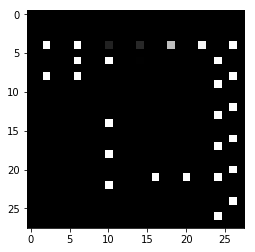

Epoch:72 Step:2400 Discriminator Loss:3.488386209937744e-05, Generator Loss:10.672216415405273


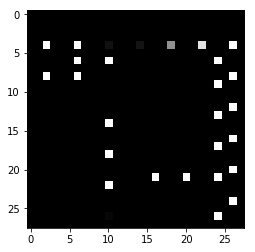

Epoch:75 Step:2500 Discriminator Loss:0.0001516812772024423, Generator Loss:10.949893951416016


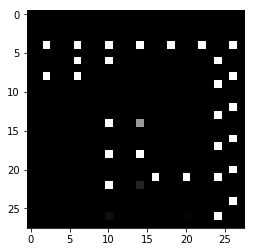

Epoch:78 Step:2600 Discriminator Loss:0.00020926959405187517, Generator Loss:11.109167098999023


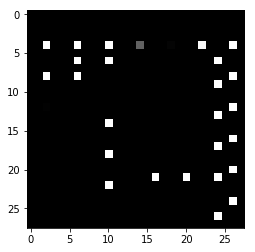

Epoch:81 Step:2700 Discriminator Loss:1.8624403310241178e-05, Generator Loss:11.243061065673828


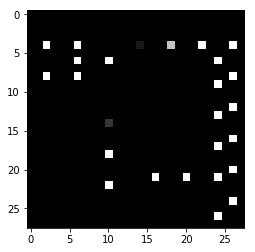

Epoch:84 Step:2800 Discriminator Loss:1.3647565538121853e-05, Generator Loss:11.4906644821167


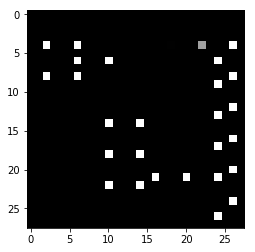

Epoch:87 Step:2900 Discriminator Loss:1.115921804739628e-05, Generator Loss:11.543045043945312


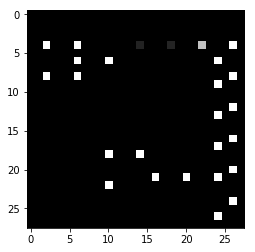

Epoch:90 Step:3000 Discriminator Loss:1.4149989510769956e-05, Generator Loss:11.703369140625


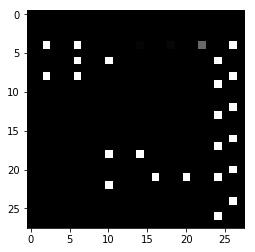

Epoch:93 Step:3100 Discriminator Loss:2.1988877051626332e-05, Generator Loss:11.788618087768555


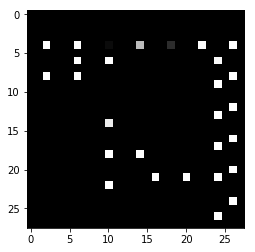

Epoch:96 Step:3200 Discriminator Loss:1.2274199434614275e-05, Generator Loss:11.919597625732422


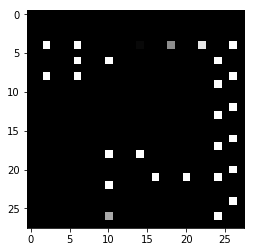

Epoch:99 Step:3300 Discriminator Loss:1.345446435152553e-05, Generator Loss:12.018165588378906


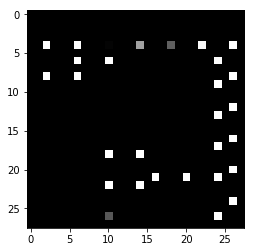

Epoch:103 Step:3400 Discriminator Loss:1.4294399079517461e-05, Generator Loss:12.145421981811523


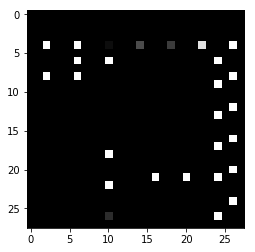

Epoch:106 Step:3500 Discriminator Loss:9.866658729151823e-06, Generator Loss:12.279960632324219


KeyboardInterrupt: 

In [35]:
tf.reset_default_graph()
losses = train(100, 3, 100, 0.01, 0.1, mnist_sample.get_batches, mnist_sample.shape, mnist_sample.image_mode )


In [16]:
def plot_loss(loss):
    loss = np.array(losses)
    fig, ax = pyplot.subplots()
    pyplot.plot(loss.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(loss.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    
plot_loss(losses)

NameError: name 'losses' is not defined

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

output shape:(?, 1)
output shape:(?, 1)
Epoch:0 Step:100 Discriminator Loss:1.9642991527410543e-23, Generator Loss:105.69554901123047


/home/carnd/deep-learning/face_generation/helper.py:108: RuntimeWarning: invalid value encountered in true_divide
  images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)


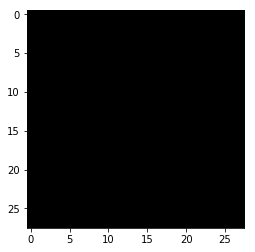

Epoch:0 Step:200 Discriminator Loss:1.1125851632508795e-24, Generator Loss:87.1134262084961


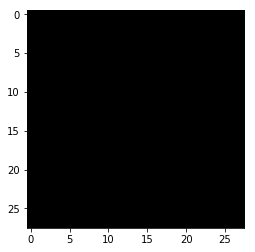

Epoch:0 Step:300 Discriminator Loss:1.1701932375789729e-22, Generator Loss:87.11277770996094


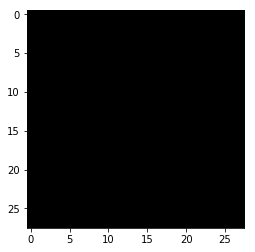

Epoch:0 Step:400 Discriminator Loss:8.604013448608245e-27, Generator Loss:87.1127700805664


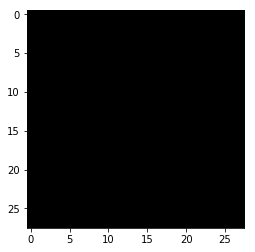

Epoch:1 Step:500 Discriminator Loss:1.0854595333346147e-29, Generator Loss:87.11278533935547


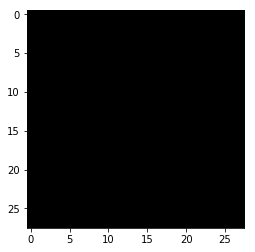

Epoch:1 Step:600 Discriminator Loss:2.505805621381871e-24, Generator Loss:87.11277770996094


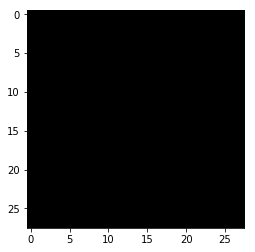

Epoch:1 Step:700 Discriminator Loss:3.8491320077642174e-24, Generator Loss:87.11277770996094


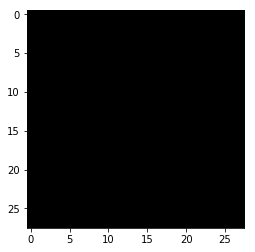

Epoch:1 Step:800 Discriminator Loss:5.701527691225598e-25, Generator Loss:87.11277770996094


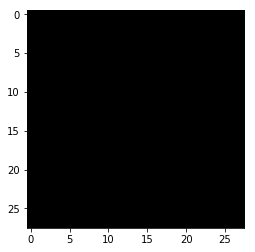

Epoch:1 Step:900 Discriminator Loss:2.8184893889386696e-26, Generator Loss:87.11277770996094


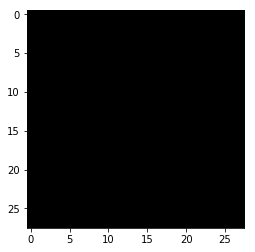

In [31]:
batch_size =128
z_dim = 100
learning_rate = 0.05
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

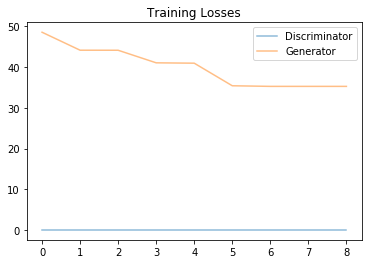

In [29]:
plot_loss(losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.